In [18]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb

from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/Denis/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [19]:
data, y = make_regression(
    n_samples=10000, n_features=10, n_informative=5, noise=20)
data = pd.DataFrame(data=data, columns=['f'+str(i+1) for i in range(data.shape[1])])
# Make data positive, add some non-linearity and 5% of outliers.
y = (y + abs(y.min())) ** 2
y[np.random.choice(range(len(y)), int(len(y)*0.05))] += y.max()
y /= 1000

features = [c for c in data.columns]
train, test, ytrain, ytest = train_test_split(data[features], y, test_size=0.25)
dtrain = lgb.Dataset(train, ytrain)
dtest = lgb.Dataset(test, ytest)

In [20]:
data.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10
0,0.252681,1.238967,0.675342,-0.333023,-1.330676,-1.594308,-1.614512,-2.155325,-0.577681,-0.567386
1,1.261571,-1.826121,-1.199831,-0.043429,-0.260731,-0.277614,-0.221847,-0.310106,-1.321985,0.092220
2,1.807328,-0.331488,1.819861,-1.793959,-0.356532,-1.564845,0.237167,1.055913,-1.095504,-1.314248
3,0.516442,1.348497,0.982388,-2.660806,-0.917717,0.816800,-0.716238,0.613369,0.085136,0.433562
4,0.083718,0.028162,1.519502,0.536281,1.049106,0.238885,0.656248,-0.135282,0.890762,-0.057526


## Custom metric

In [131]:
def mse_metric(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels) ** 2
    # name, value, is_higher_better
    return 'custom mse', np.mean(x), False

params = {
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric' : 'mse',
    'learning_rate': 0.05,
}

gbm = lgb.train(params,
                dtrain,
                num_boost_round=1000,
                valid_sets=[dtest],
                verbose_eval=10000,
                early_stopping_rounds=10)
params = {
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'learning_rate': 0.05,
}
gbm = lgb.train(params,
                dtrain,
                num_boost_round=1000,
                valid_sets=[dtest],
                verbose_eval=10000,
                feval=mse_metric,
                early_stopping_rounds=10)

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[64]	valid_0's l2: 2047.49
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[64]	valid_0's custom mse: 2047.49


In [132]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric' : 'mse',
    'learning_rate': 0.05,
}

def custom_mse(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    grad = 2 * x
    hess = 2 * np.ones(x.shape)
    return grad, hess

gbm = lgb.train(params,
                dtrain,
                num_boost_round=1000,
                valid_sets=[dtest],
                verbose_eval=10000,
                #fobj=custom_mse,
                early_stopping_rounds=10)
params = {
    'boosting_type': 'gbdt',
    'metric' : 'mse',
    'learning_rate': 0.05,
}
gbm = lgb.train(params,
                dtrain,
                num_boost_round=1000,
                valid_sets=[dtest],
                verbose_eval=10000,
                fobj=custom_mse,
                early_stopping_rounds=10)

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[64]	valid_0's l2: 2047.49
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[64]	valid_0's l2: 2047.57


In [134]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'mae',
    'metric' : 'mae',
    'learning_rate': 0.05,
}

def custom_mae(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    grad = sign(x) 
    hess = 1e-2 * np.ones(x.shape[0])
    return grad, hess

gbm = lgb.train(params,
                dtrain,
                num_boost_round=1000,
                valid_sets=[dtest],
                verbose_eval=10000,
                early_stopping_rounds=10)

gbm = lgb.train(params,
                dtrain,
                num_boost_round=10000,
                valid_sets=[dtest],
                verbose_eval=100000,
                fobj=custom_mae,
                early_stopping_rounds=10)

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[19]	valid_0's l1: 18.491
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[22]	valid_0's l1: 17.8907


In [135]:
def custom_fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    
    C = 1
    cnst = abs(x) + C
    grad = C*x / (cnst)
    hess = (C/cnst) ** 2 
    return grad, hess

params = {
    'boosting_type': 'gbdt',
    'objective': 'fair',
    'metric' : 'mae',
    'learning_rate': 0.05,
}


gbm = lgb.train(params,
                dtrain,
                num_boost_round=1000,
                valid_sets=[dtest],
                verbose_eval=10000,
                early_stopping_rounds=10)

gbm = lgb.train(params,
                dtrain,
                num_boost_round=10000,
                valid_sets=[dtest],
                verbose_eval=100000,
                fobj=custom_fair,
                early_stopping_rounds=10)

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[263]	valid_0's l1: 22.4775
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[224]	valid_0's l1: 22.1971


## Xgboost

In [ ]:
dtrain = xgb.DMatrix(train, ytrain)
dtest = xgb.DMatrix(test, ytest)
watchlist = [(dtest, 'eval')]

In [180]:
params = {
    'objective': 'reg:linear',
    'eval_metric': 'rmse', 
    'booster': 'gbtree',
    'tree_method':'hist',
    'learning_rate': 0.05
}

def custom_mse(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    grad = 2 * x
    hess = 2 * np.ones(x.shape)
    return grad, hess

gbm = xgb.train(params,
                dtrain,
                num_boost_round=1000,
                evals=watchlist,
                verbose_eval=1000,
                early_stopping_rounds=10
               )

gbm = xgb.train(params,
                dtrain,
                num_boost_round=1000,
                evals=watchlist,
                verbose_eval=1000,
                obj=custom_mse,
                early_stopping_rounds=10
               )

[0]	eval-rmse:80.0009
Will train until eval-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[62]	eval-rmse:45.5281

[0]	eval-rmse:79.9756
Will train until eval-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[63]	eval-rmse:45.6327



In [182]:
def mse_metric(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels) ** 2
    # name, value, is_higher_better
    return 'custom-mse', np.mean(np.sqrt(x))


gbm = xgb.train(params,
                dtrain,
                num_boost_round=1000,
                evals=watchlist,
                verbose_eval=1000,
                obj=custom_mse,
                early_stopping_rounds=10
               )

gbm = xgb.train(params,
                dtrain,
                num_boost_round=1000,
                evals=watchlist,
                verbose_eval=1000,
                obj=custom_mse,
                feval=mse_metric,
                early_stopping_rounds=10
               )

[0]	eval-rmse:79.9756
Will train until eval-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[63]	eval-rmse:45.6327

[0]	eval-rmse:79.9756	eval-custom-mse:61.3932
Multiple eval metrics have been passed: 'eval-custom-mse' will be used for early stopping.

Will train until eval-custom-mse hasn't improved in 10 rounds.
Stopping. Best iteration:
[38]	eval-rmse:46.3581	eval-custom-mse:19.7688



In [174]:
?xgb.train

In [170]:
params = {
    'objective': 'reg:linear',
    'eval_metric': 'mae', 
    'booster': 'gbtree',
    'tree_method':'hist',
    'learning_rate': 0.05
}

gbm = xgb.train(params,
                dtrain,
                num_boost_round=1000,
                evals=watchlist,
                verbose_eval=1000,
                early_stopping_rounds=10
               )

gbm = xgb.train(params,
                dtrain,
                num_boost_round=1000,
                evals=watchlist,
                verbose_eval=1000,
                obj=custom_mae,
                early_stopping_rounds=10
               )

gbm = xgb.train(params,
                dtrain,
                num_boost_round=1000,
                evals=watchlist,
                verbose_eval=1000,
                obj=custom_fair_obj,
                early_stopping_rounds=10
               )

[0]	train-mae:32.5997	eval-mae:31.5914
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
Stopping. Best iteration:
[215]	train-mae:15.7283	eval-mae:17.5504



In [59]:
# obj mse, eval mae: 30.103 lr 0.1
# obj mae, eval mae: 30.723 lr 0.01
# obj fair with hess, eval mae: 31.1662 lr 0.01

# after altering y:
# fair lr 0.1 : eval 1815
# fair lr 0.1 : eval 1788, constant hessian 1e-4

# mse lr 0.1 : eval 1975
# mae lr 0.01 : eval 1730 43sec per 1000 trees

In [279]:
%%time

params = {
    'boosting_type': 'gbdt',
    #'objective': 'mae',
    'metric' : 'mae',
    'num_leaves': 16,
    'learning_rate': 0.1,
}

print ('hess is 1e-4')
def custom_fair(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    
    C = 1
    cnst = abs(x) + C
    grad = C*x / (cnst)
    hess = 1e-4*np.ones(x.shape[0])
    return grad, hess

gbm = lgb.train(params,
                dtrain,
                num_boost_round=10000,
                valid_sets=[dtrain, dval],
                verbose_eval=10000,
                fobj=custom_fair,
                early_stopping_rounds=100)

print ('hess is true')
def custom_fair(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    
    C = 1
    cnst = abs(x) + C
    grad = C*x / (cnst)
    hess = (C/cnst) ** 2
    return grad, hess

gbm = lgb.train(params,
                dtrain,
                num_boost_round=10000,
                valid_sets=[dtrain, dval],
                verbose_eval=10000,
                fobj=custom_fair,
                early_stopping_rounds=100)


params = {
    'boosting_type': 'gbdt',
    #'objective': 'mae',
    'metric' : 'mae',
    'num_leaves': 16,
    'learning_rate': 0.01,
}

print ('hess is 1e-4, LR 0.01')
def custom_fair(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    
    C = 1
    cnst = abs(x) + C
    grad = C*x / (cnst)
    hess = 1e-4*np.ones(x.shape[0])
    return grad, hess

gbm = lgb.train(params,
                dtrain,
                num_boost_round=10000,
                valid_sets=[dtrain, dval],
                verbose_eval=10000,
                fobj=custom_fair,
                early_stopping_rounds=100)

print ('hess is true, LR 0.01')
def custom_fair(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    
    C = 1
    cnst = abs(x) + C
    grad = C*x / (cnst)
    hess = (C/cnst) ** 2
    return grad, hess

gbm = lgb.train(params,
                dtrain,
                num_boost_round=10000,
                valid_sets=[dtrain, dval],
                verbose_eval=10000,
                fobj=custom_fair,
                early_stopping_rounds=100)

hess is 1e-4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1333]	training's l1: 1525.46	valid_1's l1: 1788.51
hess is true
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2308]	training's l1: 1533.21	valid_1's l1: 1813.85
hess is 1e-4, LR 0.01
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4678]	training's l1: 1454.62	valid_1's l1: 1735.3
hess is true, LR 0.01
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1575]	training's l1: 1546.52	valid_1's l1: 1812.05
CPU times: user 25min 31s, sys: 2min 22s, total: 27min 54s
Wall time: 6min 10s


hess is true
Training until validation scores don't improve for 100 rounds.
[10000]	training's l1: 1900.74	valid_1's l1: 2151.8


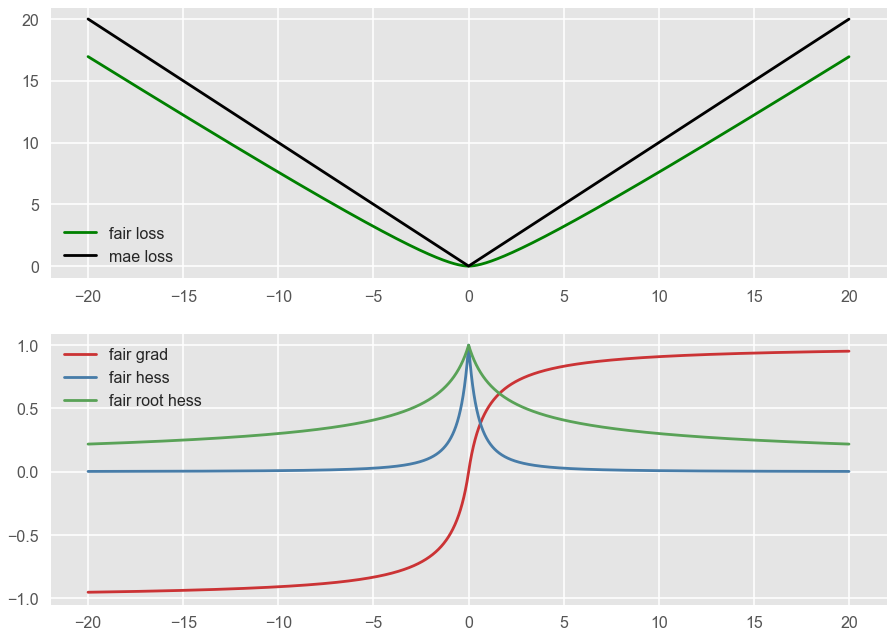

In [336]:
def fair_obj(x, C):
    loss = C*C * ( abs(x)/C - np.log(1 + abs(x)/C) )
    
    grad = C*x / (abs(x) + C)
    #hess = np.sqrt( (C/(abs(x) + C)) ** 2)
    hess = (C / (abs(x) + C) ) ** 2
    return loss, grad, hess

xs = np.arange(-20, 20, 0.01)
loss, grad, hess = fair_obj(xs, 1)

plt.figure(figsize=(15,11))
plt.subplot(2,1,1)
plt.plot(xs, loss, label='fair loss', c='green')
plt.plot(xs, abs(xs), label='mae loss', c='black')
plt.legend()

plt.subplot(2,1,2)
plt.plot(xs, grad, label='fair grad')
plt.plot(xs, hess, label='fair hess')
plt.plot(xs, np.sqrt(np.sqrt(hess)), label='fair root hess')


plt.legend()
plt.show()